# STEP 0: Prepare
---
The following is the agenda for this stage of brainmaking:
1. Import all necessary libraries
2. Obtain raw data and ferment it into a processable dataset

In [1]:
#LIBRARY IMPORT
from CyClient import *
from CyAdmin import *
from tensorflow.keras import models,layers
from tensorflow.keras.layers import Dropout,Conv1D
print('Necessary libraries imported')

Using TensorFlow backend.


CyHome's Client Package successfully imported
CyHome's Admin Package successfully imported
Necessary libraries imported


### Dataset description

A total of `500+` different strings used to prepare a solid dataset, with the followind trigger categories:
- **#LIGHTS_ON**
: Switch on the bulb in the room
- **#LIGHTS_OFF**
: Switch off the bulb in the room
- **#FAN_ON**
: Switch on the ceiling-fan
- **#FAN_OFF**
: Switch off the ceiling-fan
- **#DOOR_OPEN**
: Open and unlock the main door of the house
- **#DOOR_CLOSE**
: Close and lock the main door of the house
- **#CURTAINS_OPEN**
: Roll up and open the window curtains
- **#CURTAINS_CLOSE**
: Close and the window curtains

In [2]:
#VIEW RAW DATASET
raw=pd.read_csv('genDS.csv')
raw.head(10)

,String,Trigger
0,Turn on the lights,#LIGHTS_ON
1,Switch on the light,#LIGHTS_ON
2,Bring the lights on,#LIGHTS_ON
3,Light up the room,#LIGHTS_ON
4,Wake up light,#LIGHTS_ON
5,Get the lights running,#LIGHTS_ON
6,Turn the lights on,#LIGHTS_ON
7,Switch the light on,#LIGHTS_ON
8,Turn on the bulb,#LIGHTS_ON
9,Light up the bulb,#LIGHTS_ON


# STEP 1:Oversampling
---
**Agenda:**
1. point one
2. point two

In [9]:
from imblearn.over_sampling import RandomOverSampler
oversample = RandomOverSampler(sampling_strategy='minority')
X_over, y_over = oversample.fit_resample(X, y)

# STEP 2: Preprocess and prepare train, test
---
The following are the steps to convert a given string into a representative text vector:
1. **Decapitalise**: Lowercase all letters to avoid confusion in capitalised words
2. **Stop words**: Words like "the", "is", "to" are frequently occuring words that add no significance to the sentence. Hence, it is better to remove such words to achieve greater sentence clarity
3. **Tokenise**: Tokenisation is taken care of by the `word2vec KerasLayer` 's first layer. A total of 40000 tokens are used, which are mined from Google News Corpus
4. **Vectorise**: Finally, a 1x20 vector is returned as an output by the `word2vec KerasLayer`'s second layer.

Once the data is preprocessed, we split it into train data and test data (80:20 ratio)

In [158]:

def aggressive_fermenter(s):

    s=s.lower()
    stopwords=["i am","i "," the"," is"," and"," could","to "," please"," that","just","my"," some"," goddamn"," can"," would"," all"
              " these"," their"," those","will"," should","you"," our"," want",","," me","of "]
    for stopper in stopwords:
        s=s.replace(stopper,'')
    
    replace_rules=[["ness",""],["es","e"],["sses","ss"],["ies","y"],["s",""]]

    for rule in range(len(replace_rules)):
        regstring=replace_rules[rule][0]+r"\s+"
        endreg=replace_rules[rule][0]+r"$"
        s=re.sub(regstring,replace_rules[rule][1]+" ",s)
        s=re.sub(endreg,replace_rules[rule][1]+" ",s)
        
    
    s=re.sub(r"\s\s"," ",s)
    s=re.sub(r"^\s","",s)
    s=re.sub(r"\s$","",s)
    return s

import tensorflow_hub as hub
pretrained_model='word2vec'
word2vec=hub.KerasLayer(pretrained_model,input_shape=[],dtype=tf.string,trainable=True)
GENTEXT=[]
for i in raw.String:
    GENTEXT.append(aggressive_fermenter(i))
       

In [159]:
#TRAIN TEST SPLIT
x_np=word2vec(GENTEXT).numpy()
GENTEXT=np.array(GENTEXT)
dicto={}
count=0
y_np=[]
for i in raw.Trigger:
    if i in dicto.keys():
        y_np.append(dicto[i])
    else:
        dicto[i]=count
        count+=1
        y_np.append(dicto[i])
revdicto={}
for i in dicto.keys():
    revdicto[dicto[i]]=i;
y_tar=y_np
y_np=np.eye(np.max(y_np)+1)[y_np]
#print('Trigger enumeration results: ',y_np) 

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(GENTEXT, y_np,test_size=0.20, random_state=1)
x_train.shape,y_train.shape,x_test.shape,y_test.shape

((401,), (401, 8), (101,), (101, 8))

# STEP 4: BrainMaking
---
**Architecture:**
1. Word2vec layer
2. 20 noded dense layer
3. 8 noded dense output, with softmax activation

*The following is an illustrative diagram of the developed taskbrain's architecture*
![architecture](CyArch.png)


In [18]:

def build_model():
    taskbrain=models.Sequential()
    taskbrain.add(word2vec)
    taskbrain.add(layers.Dense(16))
    taskbrain.add(Dropout(0.2))
    taskbrain.add(layers.Dense(32))
    taskbrain.add(Dropout(0.2))
    taskbrain.add(layers.Dense(64))
    taskbrain.add(Dropout(0.4))
    taskbrain.add(layers.Dense(128))
    taskbrain.add(Dropout(0.4))
    taskbrain.add(layers.Dense(64))
    taskbrain.add(Dropout(0.2))
    taskbrain.add(layers.Dense(8,activation='softmax',input_shape=(20,)))
    taskbrain.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['accuracy','mae','mse'])
    return taskbrain

def build_model1():
    taskbrain=models.Sequential()
    taskbrain.add(word2vec)
    taskbrain.add(layers.Dense(20))
    taskbrain.add(Dropout(0.3))
    taskbrain.add(layers.Dense(8,activation='softmax',input_shape=(20,)))
    taskbrain.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy','mae','mse'])
    return taskbrain

def build_model2():
    taskbrain=models.Sequential()
    taskbrain.add(word2vec)
    taskbrain.add(layers.Dense(20))
    taskbrain.add(Dropout(0.5))
    taskbrain.add(layers.Dense(8,activation='softmax',input_shape=(20,)))
    taskbrain.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['accuracy','mae','mse'])
    return taskbrain

# STEP 5: Training with Cross Validation 
---
**Agenda:**
* use k=10 folds
* use x_train and y_train for splitting into separate k fold validation sets
* store training results of each fold
* plot graphs for all k-fold validation sessions

In [13]:
#parameters 1:
from keras.callbacks import EarlyStopping
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
k=10
print('training in progress:...\n\n')
num_val_samples = len(x_train) // k
num_epochs = 100
all_scores = []
all_acc=[]
allmodels=[]
history=[]
for i in range(k):
    print('\nprocessing fold #', i)
    val_data = x_train[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = y_train[i * num_val_samples: (i + 1) * num_val_samples]
    partial_x_train = np.concatenate(
        [x_train[:i * num_val_samples],
        x_train[(i + 1) * num_val_samples:]],
        axis=0)
    partial_y_train = np.concatenate(
        [y_train[:i * num_val_samples],
        y_train[(i + 1) * num_val_samples:]],
        axis=0)
    model = build_model1()
    cur_history=model.fit(partial_x_train, partial_y_train, epochs=num_epochs, batch_size=64, validation_data=(val_data,val_targets),callbacks=[callback]);
    loss,acc,mae,mse=model.evaluate(val_data, val_targets)
    allmodels.append(model);
    history.append(cur_history)
    all_scores.append(mae)
    all_acc.append(acc)
    print('='*100)
    

training in progress:...



processing fold # 0
Epoch 1/100
3/3 [==============================] - 0s 92ms/step - loss: 3.7958 - accuracy: 0.0170 - mae: 0.2364 - mse: 0.1568 - val_loss: 3.6149 - val_accuracy: 0.0000e+00 - val_mae: 0.2376 - val_mse: 0.1595
Epoch 2/100
3/3 [==============================] - 0s 14ms/step - loss: 3.5994 - accuracy: 0.0170 - mae: 0.2348 - mse: 0.1540 - val_loss: 3.4282 - val_accuracy: 0.0526 - val_mae: 0.2357 - val_mse: 0.1552
Epoch 3/100
3/3 [==============================] - 0s 14ms/step - loss: 3.4569 - accuracy: 0.0568 - mae: 0.2329 - mse: 0.1519 - val_loss: 3.2471 - val_accuracy: 0.0526 - val_mae: 0.2337 - val_mse: 0.1508
Epoch 4/100
3/3 [==============================] - 0s 13ms/step - loss: 3.4083 - accuracy: 0.0511 - mae: 0.2341 - mse: 0.1525 - val_loss: 3.0741 - val_accuracy: 0.0526 - val_mae: 0.2315 - val_mse: 0.1462
Epoch 5/100
3/3 [==============================] - 0s 15ms/step - loss: 3.0774 - accuracy: 0.0852 - mae: 0.2276 - mse: 0.1426 - val_

In [125]:
#parameters 2:
from keras.callbacks import EarlyStopping
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
k=10
print('training in progress:...\n\n')
num_val_samples = len(x_train) // k
num_epochs = 100
all_scores = []
all_acc=[]
history=[]
allmodels=[]
for i in range(k):
    print('\nprocessing fold #', i)
    val_data = x_train[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = y_train[i * num_val_samples: (i + 1) * num_val_samples]
    partial_x_train = np.concatenate(
        [x_train[:i * num_val_samples],
        x_train[(i + 1) * num_val_samples:]],
        axis=0)
    partial_y_train = np.concatenate(
        [y_train[:i * num_val_samples],
        y_train[(i + 1) * num_val_samples:]],
        axis=0)
    model = build_model2()
    cur_history=model.fit(partial_x_train, partial_y_train, epochs=num_epochs, batch_size=10, validation_data=(val_data,val_targets),callbacks=[callback]);
    loss,acc,mae,mse=model.evaluate(val_data, val_targets)
    history.append(cur_history)
    allmodels.append(model);
    all_scores.append(mae)
    all_acc.append(acc)
    print('='*100)
    

training in progress:...



processing fold # 0
Epoch 1/100
18/18 [==============================] - 0s 28ms/step - loss: 4.7371 - accuracy: 0.0284 - mae: 0.2354 - mse: 0.1713 - val_loss: 2.2090 - val_accuracy: 0.1579 - val_mae: 0.2084 - val_mse: 0.1170
Epoch 2/100
18/18 [==============================] - 0s 18ms/step - loss: 3.8286 - accuracy: 0.0682 - mae: 0.2270 - mse: 0.1567 - val_loss: 1.6216 - val_accuracy: 0.4737 - val_mae: 0.1805 - val_mse: 0.0887
Epoch 3/100
18/18 [==============================] - 0s 8ms/step - loss: 2.9868 - accuracy: 0.1818 - mae: 0.2083 - mse: 0.1359 - val_loss: 1.2225 - val_accuracy: 0.6316 - val_mae: 0.1531 - val_mse: 0.0674
Epoch 4/100
18/18 [==============================] - 0s 9ms/step - loss: 2.2941 - accuracy: 0.2784 - mae: 0.1897 - mse: 0.1142 - val_loss: 0.9296 - val_accuracy: 0.6842 - val_mae: 0.1291 - val_mse: 0.0524
Epoch 5/100
18/18 [==============================] - 0s 8ms/step - loss: 1.8264 - accuracy: 0.3352 - mae: 0.1729 - mse: 0.1013 - v

In [12]:
#parameters 3:
k=10
print('training in progress:...\n\n')
num_val_samples = len(x_train) // k
num_epochs = 30
all_scores = []
all_acc=[]
history=[]
for i in range(k):
    print('\nprocessing fold #', i)
    val_data = x_train[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = y_train[i * num_val_samples: (i + 1) * num_val_samples]
    partial_x_train = np.concatenate(
        [x_train[:i * num_val_samples],
        x_train[(i + 1) * num_val_samples:]],
        axis=0)
    partial_y_train = np.concatenate(
        [y_train[:i * num_val_samples],
        y_train[(i + 1) * num_val_samples:]],
        axis=0)
    model = build_model()
    cur_history=model.fit(partial_x_train, partial_y_train, epochs=num_epochs, batch_size=10, validation_data=(val_data,val_targets));
    loss,acc,mae,mse=model.evaluate(val_data, val_targets)
    history.append(cur_history)
    all_scores.append(mae)
    all_acc.append(acc)
    print('='*100)
    

training in progress:...



processing fold # 0
Epoch 1/30
18/18 [==============================] - 1s 60ms/step - loss: 2.5256 - accuracy: 0.1307 - mae: 0.2140 - mse: 0.1353 - val_loss: 2.0215 - val_accuracy: 0.0526 - val_mae: 0.2089 - val_mse: 0.1201
Epoch 2/30
18/18 [==============================] - 0s 9ms/step - loss: 1.5973 - accuracy: 0.3580 - mae: 0.1784 - mse: 0.0955 - val_loss: 1.2953 - val_accuracy: 0.5263 - val_mae: 0.1726 - val_mse: 0.0824
Epoch 3/30
18/18 [==============================] - 0s 15ms/step - loss: 1.0663 - accuracy: 0.5682 - mae: 0.1454 - mse: 0.0655 - val_loss: 0.8293 - val_accuracy: 0.7895 - val_mae: 0.1333 - val_mse: 0.0523
Epoch 4/30
18/18 [==============================] - 0s 16ms/step - loss: 0.7243 - accuracy: 0.8239 - mae: 0.1134 - mse: 0.0428 - val_loss: 0.5468 - val_accuracy: 0.8421 - val_mae: 0.0970 - val_mse: 0.0321
Epoch 5/30
18/18 [==============================] - 0s 10ms/step - loss: 0.5141 - accuracy: 0.8750 - mae: 0.0871 - mse: 0.0287 - val_

In [13]:
#parameters 4:
k=10
print('training in progress:...\n\n')
num_val_samples = len(x_train) // k
num_epochs = 30
all_scores = []
all_acc=[]
history=[]
for i in range(k):
    print('\nprocessing fold #', i)
    val_data = x_train[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = y_train[i * num_val_samples: (i + 1) * num_val_samples]
    partial_x_train = np.concatenate(
        [x_train[:i * num_val_samples],
        x_train[(i + 1) * num_val_samples:]],
        axis=0)
    partial_y_train = np.concatenate(
        [y_train[:i * num_val_samples],
        y_train[(i + 1) * num_val_samples:]],
        axis=0)
    model = build_model()
    cur_history=model.fit(partial_x_train, partial_y_train, epochs=num_epochs, batch_size=32, validation_data=(val_data,val_targets));
    loss,acc,mae,mse=model.evaluate(val_data, val_targets)
    history.append(cur_history)
    all_scores.append(mae)
    all_acc.append(acc)
    print('='*100)
    

training in progress:...



processing fold # 0
Epoch 1/30
6/6 [==============================] - 0s 71ms/step - loss: 4.2169 - accuracy: 0.0455 - mae: 0.2342 - mse: 0.1628 - val_loss: 3.2381 - val_accuracy: 0.1053 - val_mae: 0.2288 - val_mse: 0.1528
Epoch 2/30
6/6 [==============================] - 0s 11ms/step - loss: 3.3393 - accuracy: 0.0852 - mae: 0.2259 - mse: 0.1464 - val_loss: 2.5702 - val_accuracy: 0.1053 - val_mae: 0.2182 - val_mse: 0.1356
Epoch 3/30
6/6 [==============================] - 0s 19ms/step - loss: 2.7757 - accuracy: 0.1307 - mae: 0.2171 - mse: 0.1334 - val_loss: 2.0914 - val_accuracy: 0.2105 - val_mae: 0.2052 - val_mse: 0.1193
Epoch 4/30
6/6 [==============================] - 0s 14ms/step - loss: 2.3228 - accuracy: 0.2216 - mae: 0.2064 - mse: 0.1207 - val_loss: 1.6883 - val_accuracy: 0.3684 - val_mae: 0.1893 - val_mse: 0.1022
Epoch 5/30
6/6 [==============================] - 0s 21ms/step - loss: 1.9456 - accuracy: 0.2614 - mae: 0.1948 - mse: 0.1081 - val_loss: 1.3

In [19]:
#parameters 5:

from keras.callbacks import EarlyStopping
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
k=10
print('training in progress:...\n\n')
num_val_samples = len(x_train) // k
num_epochs = 100
all_scores = []
all_acc=[]
history=[]
allmodels=[]
for i in range(k):
    print('\nprocessing fold #', i)
    val_data = x_train[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = y_train[i * num_val_samples: (i + 1) * num_val_samples]
    partial_x_train = np.concatenate(
        [x_train[:i * num_val_samples],
        x_train[(i + 1) * num_val_samples:]],
        axis=0)
    partial_y_train = np.concatenate(
        [y_train[:i * num_val_samples],
        y_train[(i + 1) * num_val_samples:]],
        axis=0)
    model = build_model()
    cur_history=model.fit(partial_x_train, partial_y_train, epochs=num_epochs, batch_size=64, validation_data=(val_data,val_targets),callbacks=[callback]);
    allmodels.append(model);
    loss,acc,mae,mse=model.evaluate(val_data, val_targets)
    history.append(cur_history)
    all_scores.append(mae)
    all_acc.append(acc)
    print('='*100)
    

training in progress:...



processing fold # 0
Epoch 1/100
6/6 [==============================] - 0s 61ms/step - loss: 2.4772 - accuracy: 0.1053 - mae: 0.2188 - mse: 0.1252 - val_loss: 2.3088 - val_accuracy: 0.1750 - val_mae: 0.2137 - val_mse: 0.1162
Epoch 2/100
6/6 [==============================] - 0s 9ms/step - loss: 2.3055 - accuracy: 0.1413 - mae: 0.2164 - mse: 0.1169 - val_loss: 2.1991 - val_accuracy: 0.2000 - val_mae: 0.2131 - val_mse: 0.1121
Epoch 3/100
6/6 [==============================] - 0s 10ms/step - loss: 2.1933 - accuracy: 0.1551 - mae: 0.2147 - mse: 0.1128 - val_loss: 2.1226 - val_accuracy: 0.1750 - val_mae: 0.2124 - val_mse: 0.1096
Epoch 4/100
6/6 [==============================] - 0s 10ms/step - loss: 2.1057 - accuracy: 0.1828 - mae: 0.2125 - mse: 0.1101 - val_loss: 2.0624 - val_accuracy: 0.2500 - val_mae: 0.2115 - val_mse: 0.1077
Epoch 5/100
6/6 [==============================] - 0s 10ms/step - loss: 2.0234 - accuracy: 0.1967 - mae: 0.2102 - mse: 0.1071 - val_loss:

Epoch 41/100
6/6 [==============================] - 0s 10ms/step - loss: 0.8942 - accuracy: 0.7341 - mae: 0.1347 - mse: 0.0547 - val_loss: 0.9258 - val_accuracy: 0.7000 - val_mae: 0.1393 - val_mse: 0.0593
Epoch 42/100
6/6 [==============================] - 0s 10ms/step - loss: 0.8475 - accuracy: 0.7701 - mae: 0.1307 - mse: 0.0518 - val_loss: 0.9031 - val_accuracy: 0.7000 - val_mae: 0.1368 - val_mse: 0.0580
Epoch 43/100
6/6 [==============================] - 0s 11ms/step - loss: 0.8246 - accuracy: 0.7590 - mae: 0.1277 - mse: 0.0504 - val_loss: 0.8792 - val_accuracy: 0.7000 - val_mae: 0.1342 - val_mse: 0.0566
Epoch 44/100
6/6 [==============================] - 0s 11ms/step - loss: 0.8067 - accuracy: 0.7756 - mae: 0.1259 - mse: 0.0497 - val_loss: 0.8570 - val_accuracy: 0.7000 - val_mae: 0.1318 - val_mse: 0.0553
Epoch 45/100
6/6 [==============================] - 0s 15ms/step - loss: 0.7947 - accuracy: 0.7812 - mae: 0.1235 - mse: 0.0484 - val_loss: 0.8343 - val_accuracy: 0.7000 - val_mae: 

Epoch 81/100
6/6 [==============================] - 0s 11ms/step - loss: 0.2574 - accuracy: 0.9557 - mae: 0.0471 - mse: 0.0144 - val_loss: 0.4060 - val_accuracy: 0.8500 - val_mae: 0.0632 - val_mse: 0.0296
Epoch 82/100
6/6 [==============================] - 0s 11ms/step - loss: 0.2489 - accuracy: 0.9557 - mae: 0.0465 - mse: 0.0140 - val_loss: 0.4003 - val_accuracy: 0.8500 - val_mae: 0.0616 - val_mse: 0.0293
Epoch 83/100
6/6 [==============================] - 0s 19ms/step - loss: 0.2252 - accuracy: 0.9640 - mae: 0.0435 - mse: 0.0124 - val_loss: 0.3968 - val_accuracy: 0.8750 - val_mae: 0.0603 - val_mse: 0.0291
Epoch 84/100
6/6 [==============================] - 0s 12ms/step - loss: 0.2211 - accuracy: 0.9612 - mae: 0.0426 - mse: 0.0123 - val_loss: 0.3929 - val_accuracy: 0.8750 - val_mae: 0.0597 - val_mse: 0.0289
Epoch 85/100
6/6 [==============================] - 0s 10ms/step - loss: 0.2069 - accuracy: 0.9640 - mae: 0.0401 - mse: 0.0111 - val_loss: 0.3877 - val_accuracy: 0.8500 - val_mae: 

Epoch 26/100
6/6 [==============================] - 0s 15ms/step - loss: 0.8226 - accuracy: 0.7784 - mae: 0.1283 - mse: 0.0505 - val_loss: 0.7429 - val_accuracy: 0.8750 - val_mae: 0.1216 - val_mse: 0.0435
Epoch 27/100
6/6 [==============================] - 0s 12ms/step - loss: 0.7750 - accuracy: 0.7784 - mae: 0.1212 - mse: 0.0469 - val_loss: 0.7099 - val_accuracy: 0.8750 - val_mae: 0.1177 - val_mse: 0.0415
Epoch 28/100
6/6 [==============================] - 0s 13ms/step - loss: 0.7296 - accuracy: 0.8227 - mae: 0.1167 - mse: 0.0439 - val_loss: 0.6775 - val_accuracy: 0.8750 - val_mae: 0.1137 - val_mse: 0.0394
Epoch 29/100
6/6 [==============================] - 0s 20ms/step - loss: 0.7028 - accuracy: 0.8283 - mae: 0.1149 - mse: 0.0428 - val_loss: 0.6420 - val_accuracy: 0.8750 - val_mae: 0.1092 - val_mse: 0.0371
Epoch 30/100
6/6 [==============================] - 0s 12ms/step - loss: 0.6552 - accuracy: 0.8560 - mae: 0.1088 - mse: 0.0398 - val_loss: 0.6087 - val_accuracy: 0.8750 - val_mae: 

Epoch 5/100
6/6 [==============================] - 0s 10ms/step - loss: 1.7391 - accuracy: 0.3130 - mae: 0.1948 - mse: 0.0993 - val_loss: 1.6522 - val_accuracy: 0.3000 - val_mae: 0.1971 - val_mse: 0.0970
Epoch 6/100
6/6 [==============================] - 0s 9ms/step - loss: 1.6458 - accuracy: 0.3601 - mae: 0.1914 - mse: 0.0958 - val_loss: 1.5576 - val_accuracy: 0.3750 - val_mae: 0.1922 - val_mse: 0.0926
Epoch 7/100
6/6 [==============================] - 0s 9ms/step - loss: 1.5648 - accuracy: 0.3657 - mae: 0.1866 - mse: 0.0917 - val_loss: 1.4729 - val_accuracy: 0.4500 - val_mae: 0.1873 - val_mse: 0.0884
Epoch 8/100
6/6 [==============================] - 0s 9ms/step - loss: 1.4381 - accuracy: 0.4321 - mae: 0.1793 - mse: 0.0856 - val_loss: 1.3941 - val_accuracy: 0.5250 - val_mae: 0.1822 - val_mse: 0.0843
Epoch 9/100
6/6 [==============================] - 0s 10ms/step - loss: 1.3726 - accuracy: 0.4737 - mae: 0.1746 - mse: 0.0823 - val_loss: 1.3186 - val_accuracy: 0.6000 - val_mae: 0.1772 -

6/6 [==============================] - 0s 9ms/step - loss: 0.2318 - accuracy: 0.9612 - mae: 0.0451 - mse: 0.0128 - val_loss: 0.2486 - val_accuracy: 0.9000 - val_mae: 0.0497 - val_mse: 0.0148
Epoch 46/100
6/6 [==============================] - 0s 9ms/step - loss: 0.2055 - accuracy: 0.9640 - mae: 0.0405 - mse: 0.0109 - val_loss: 0.2421 - val_accuracy: 0.9000 - val_mae: 0.0482 - val_mse: 0.0146
Epoch 47/100
6/6 [==============================] - 0s 10ms/step - loss: 0.2037 - accuracy: 0.9723 - mae: 0.0401 - mse: 0.0113 - val_loss: 0.2375 - val_accuracy: 0.9000 - val_mae: 0.0472 - val_mse: 0.0145
Epoch 48/100
6/6 [==============================] - 0s 17ms/step - loss: 0.2163 - accuracy: 0.9501 - mae: 0.0411 - mse: 0.0125 - val_loss: 0.2282 - val_accuracy: 0.9000 - val_mae: 0.0454 - val_mse: 0.0139
Epoch 49/100
6/6 [==============================] - 0s 10ms/step - loss: 0.1918 - accuracy: 0.9640 - mae: 0.0368 - mse: 0.0106 - val_loss: 0.2153 - val_accuracy: 0.9000 - val_mae: 0.0433 - val_ms

Epoch 10/100
6/6 [==============================] - 0s 9ms/step - loss: 1.4853 - accuracy: 0.4460 - mae: 0.1833 - mse: 0.0871 - val_loss: 1.4140 - val_accuracy: 0.5750 - val_mae: 0.1810 - val_mse: 0.0823
Epoch 11/100
6/6 [==============================] - 0s 9ms/step - loss: 1.4108 - accuracy: 0.5042 - mae: 0.1779 - mse: 0.0829 - val_loss: 1.3369 - val_accuracy: 0.5750 - val_mae: 0.1760 - val_mse: 0.0783
Epoch 12/100
6/6 [==============================] - 0s 9ms/step - loss: 1.3243 - accuracy: 0.5208 - mae: 0.1730 - mse: 0.0784 - val_loss: 1.2598 - val_accuracy: 0.5750 - val_mae: 0.1706 - val_mse: 0.0741
Epoch 13/100
6/6 [==============================] - 0s 10ms/step - loss: 1.2224 - accuracy: 0.6011 - mae: 0.1660 - mse: 0.0732 - val_loss: 1.1817 - val_accuracy: 0.6750 - val_mae: 0.1646 - val_mse: 0.0695
Epoch 14/100
6/6 [==============================] - 0s 9ms/step - loss: 1.1619 - accuracy: 0.6593 - mae: 0.1618 - mse: 0.0701 - val_loss: 1.1123 - val_accuracy: 0.7500 - val_mae: 0.15

6/6 [==============================] - 0s 10ms/step - loss: 0.1577 - accuracy: 0.9751 - mae: 0.0304 - mse: 0.0083 - val_loss: 0.1270 - val_accuracy: 1.0000 - val_mae: 0.0272 - val_mse: 0.0051
Epoch 51/100
6/6 [==============================] - 0s 9ms/step - loss: 0.1794 - accuracy: 0.9612 - mae: 0.0329 - mse: 0.0104 - val_loss: 0.1210 - val_accuracy: 1.0000 - val_mae: 0.0260 - val_mse: 0.0049
Epoch 52/100
6/6 [==============================] - 0s 9ms/step - loss: 0.1569 - accuracy: 0.9668 - mae: 0.0296 - mse: 0.0084 - val_loss: 0.1152 - val_accuracy: 1.0000 - val_mae: 0.0249 - val_mse: 0.0046
Epoch 53/100
6/6 [==============================] - 0s 9ms/step - loss: 0.1544 - accuracy: 0.9668 - mae: 0.0293 - mse: 0.0086 - val_loss: 0.1101 - val_accuracy: 1.0000 - val_mae: 0.0238 - val_mse: 0.0044
Epoch 54/100
6/6 [==============================] - 0s 9ms/step - loss: 0.1487 - accuracy: 0.9778 - mae: 0.0287 - mse: 0.0079 - val_loss: 0.1032 - val_accuracy: 1.0000 - val_mae: 0.0225 - val_mse:

Epoch 31/100
6/6 [==============================] - 0s 10ms/step - loss: 0.2753 - accuracy: 0.9335 - mae: 0.0500 - mse: 0.0160 - val_loss: 0.2048 - val_accuracy: 0.9750 - val_mae: 0.0361 - val_mse: 0.0105
Epoch 32/100
6/6 [==============================] - 0s 10ms/step - loss: 0.2291 - accuracy: 0.9446 - mae: 0.0435 - mse: 0.0128 - val_loss: 0.1960 - val_accuracy: 0.9750 - val_mae: 0.0344 - val_mse: 0.0102
Epoch 33/100
6/6 [==============================] - 0s 9ms/step - loss: 0.2140 - accuracy: 0.9612 - mae: 0.0406 - mse: 0.0117 - val_loss: 0.1904 - val_accuracy: 0.9750 - val_mae: 0.0332 - val_mse: 0.0101
Epoch 34/100
6/6 [==============================] - 0s 10ms/step - loss: 0.2236 - accuracy: 0.9335 - mae: 0.0406 - mse: 0.0126 - val_loss: 0.1846 - val_accuracy: 0.9750 - val_mae: 0.0322 - val_mse: 0.0099
Epoch 35/100
6/6 [==============================] - 0s 20ms/step - loss: 0.1985 - accuracy: 0.9723 - mae: 0.0368 - mse: 0.0105 - val_loss: 0.1782 - val_accuracy: 0.9750 - val_mae: 0

Epoch 25/100
6/6 [==============================] - 0s 19ms/step - loss: 0.3186 - accuracy: 0.9141 - mae: 0.0577 - mse: 0.0183 - val_loss: 0.2501 - val_accuracy: 0.9500 - val_mae: 0.0511 - val_mse: 0.0126
Epoch 26/100
6/6 [==============================] - 0s 13ms/step - loss: 0.2866 - accuracy: 0.9446 - mae: 0.0536 - mse: 0.0159 - val_loss: 0.2326 - val_accuracy: 0.9500 - val_mae: 0.0478 - val_mse: 0.0116
Epoch 27/100
6/6 [==============================] - 0s 19ms/step - loss: 0.2837 - accuracy: 0.9474 - mae: 0.0530 - mse: 0.0153 - val_loss: 0.2181 - val_accuracy: 0.9500 - val_mae: 0.0449 - val_mse: 0.0109
Epoch 28/100
6/6 [==============================] - 0s 21ms/step - loss: 0.2619 - accuracy: 0.9501 - mae: 0.0486 - mse: 0.0143 - val_loss: 0.2056 - val_accuracy: 0.9750 - val_mae: 0.0424 - val_mse: 0.0103
Epoch 29/100
6/6 [==============================] - 0s 13ms/step - loss: 0.2599 - accuracy: 0.9474 - mae: 0.0490 - mse: 0.0141 - val_loss: 0.1953 - val_accuracy: 0.9750 - val_mae: 

Epoch 16/100
6/6 [==============================] - 0s 13ms/step - loss: 0.5942 - accuracy: 0.8643 - mae: 0.0986 - mse: 0.0343 - val_loss: 0.4643 - val_accuracy: 0.9750 - val_mae: 0.0859 - val_mse: 0.0248
Epoch 17/100
6/6 [==============================] - 0s 13ms/step - loss: 0.5152 - accuracy: 0.9030 - mae: 0.0878 - mse: 0.0287 - val_loss: 0.4317 - val_accuracy: 0.9750 - val_mae: 0.0808 - val_mse: 0.0228
Epoch 18/100
6/6 [==============================] - 0s 20ms/step - loss: 0.5008 - accuracy: 0.8892 - mae: 0.0862 - mse: 0.0289 - val_loss: 0.3933 - val_accuracy: 0.9750 - val_mae: 0.0749 - val_mse: 0.0203
Epoch 19/100
6/6 [==============================] - 0s 14ms/step - loss: 0.4496 - accuracy: 0.9030 - mae: 0.0791 - mse: 0.0247 - val_loss: 0.3649 - val_accuracy: 0.9750 - val_mae: 0.0703 - val_mse: 0.0185
Epoch 20/100
6/6 [==============================] - 0s 19ms/step - loss: 0.4404 - accuracy: 0.9197 - mae: 0.0759 - mse: 0.0249 - val_loss: 0.3400 - val_accuracy: 1.0000 - val_mae: 

Epoch 6/100
6/6 [==============================] - 0s 18ms/step - loss: 1.5221 - accuracy: 0.4377 - mae: 0.1820 - mse: 0.0875 - val_loss: 1.2641 - val_accuracy: 0.6250 - val_mae: 0.1707 - val_mse: 0.0756
Epoch 7/100
6/6 [==============================] - 0s 17ms/step - loss: 1.4051 - accuracy: 0.5263 - mae: 0.1747 - mse: 0.0816 - val_loss: 1.1447 - val_accuracy: 0.6750 - val_mae: 0.1625 - val_mse: 0.0689
Epoch 8/100
6/6 [==============================] - 0s 11ms/step - loss: 1.2734 - accuracy: 0.5817 - mae: 0.1669 - mse: 0.0748 - val_loss: 1.0335 - val_accuracy: 0.7000 - val_mae: 0.1535 - val_mse: 0.0621
Epoch 9/100
6/6 [==============================] - 0s 11ms/step - loss: 1.1506 - accuracy: 0.6427 - mae: 0.1576 - mse: 0.0681 - val_loss: 0.9338 - val_accuracy: 0.7750 - val_mae: 0.1447 - val_mse: 0.0557
Epoch 10/100
6/6 [==============================] - 0s 14ms/step - loss: 1.0645 - accuracy: 0.7036 - mae: 0.1508 - mse: 0.0632 - val_loss: 0.8462 - val_accuracy: 0.8250 - val_mae: 0.13

Epoch 46/100
6/6 [==============================] - 0s 13ms/step - loss: 0.1230 - accuracy: 0.9695 - mae: 0.0226 - mse: 0.0073 - val_loss: 0.0815 - val_accuracy: 1.0000 - val_mae: 0.0180 - val_mse: 0.0033
Epoch 47/100
6/6 [==============================] - 0s 20ms/step - loss: 0.1020 - accuracy: 0.9834 - mae: 0.0197 - mse: 0.0051 - val_loss: 0.0786 - val_accuracy: 1.0000 - val_mae: 0.0174 - val_mse: 0.0032
Epoch 48/100
6/6 [==============================] - 0s 20ms/step - loss: 0.1010 - accuracy: 0.9778 - mae: 0.0179 - mse: 0.0048 - val_loss: 0.0777 - val_accuracy: 1.0000 - val_mae: 0.0170 - val_mse: 0.0034
Epoch 49/100
6/6 [==============================] - 0s 20ms/step - loss: 0.1030 - accuracy: 0.9834 - mae: 0.0193 - mse: 0.0054 - val_loss: 0.0771 - val_accuracy: 0.9750 - val_mae: 0.0166 - val_mse: 0.0035
Epoch 50/100
6/6 [==============================] - 0s 14ms/step - loss: 0.1084 - accuracy: 0.9723 - mae: 0.0191 - mse: 0.0060 - val_loss: 0.0739 - val_accuracy: 0.9750 - val_mae: 

Epoch 30/100
6/6 [==============================] - 0s 14ms/step - loss: 0.1733 - accuracy: 0.9751 - mae: 0.0338 - mse: 0.0094 - val_loss: 0.1929 - val_accuracy: 0.9500 - val_mae: 0.0299 - val_mse: 0.0112
Epoch 31/100
6/6 [==============================] - 0s 20ms/step - loss: 0.1664 - accuracy: 0.9778 - mae: 0.0320 - mse: 0.0086 - val_loss: 0.1919 - val_accuracy: 0.9500 - val_mae: 0.0289 - val_mse: 0.0111
Epoch 32/100
6/6 [==============================] - 0s 13ms/step - loss: 0.1530 - accuracy: 0.9723 - mae: 0.0300 - mse: 0.0080 - val_loss: 0.1865 - val_accuracy: 0.9500 - val_mae: 0.0281 - val_mse: 0.0109
Epoch 33/100
6/6 [==============================] - 0s 20ms/step - loss: 0.1508 - accuracy: 0.9751 - mae: 0.0297 - mse: 0.0080 - val_loss: 0.1850 - val_accuracy: 0.9500 - val_mae: 0.0270 - val_mse: 0.0108
Epoch 34/100
6/6 [==============================] - 0s 14ms/step - loss: 0.1372 - accuracy: 0.9695 - mae: 0.0272 - mse: 0.0070 - val_loss: 0.1832 - val_accuracy: 0.9500 - val_mae: 

Epoch 15/100
6/6 [==============================] - 0s 15ms/step - loss: 0.8062 - accuracy: 0.7618 - mae: 0.1182 - mse: 0.0482 - val_loss: 0.6346 - val_accuracy: 0.8750 - val_mae: 0.1052 - val_mse: 0.0345
Epoch 16/100
6/6 [==============================] - 0s 13ms/step - loss: 0.7134 - accuracy: 0.8227 - mae: 0.1074 - mse: 0.0410 - val_loss: 0.5769 - val_accuracy: 0.9250 - val_mae: 0.0973 - val_mse: 0.0309
Epoch 17/100
6/6 [==============================] - 0s 19ms/step - loss: 0.7024 - accuracy: 0.7922 - mae: 0.1080 - mse: 0.0419 - val_loss: 0.5274 - val_accuracy: 0.9250 - val_mae: 0.0901 - val_mse: 0.0279
Epoch 18/100
6/6 [==============================] - 0s 14ms/step - loss: 0.5847 - accuracy: 0.8366 - mae: 0.0937 - mse: 0.0340 - val_loss: 0.4813 - val_accuracy: 0.9250 - val_mae: 0.0837 - val_mse: 0.0251
Epoch 19/100
6/6 [==============================] - 0s 20ms/step - loss: 0.5421 - accuracy: 0.8560 - mae: 0.0882 - mse: 0.0311 - val_loss: 0.4396 - val_accuracy: 0.9500 - val_mae: 

Cross validations acc and mae graphs


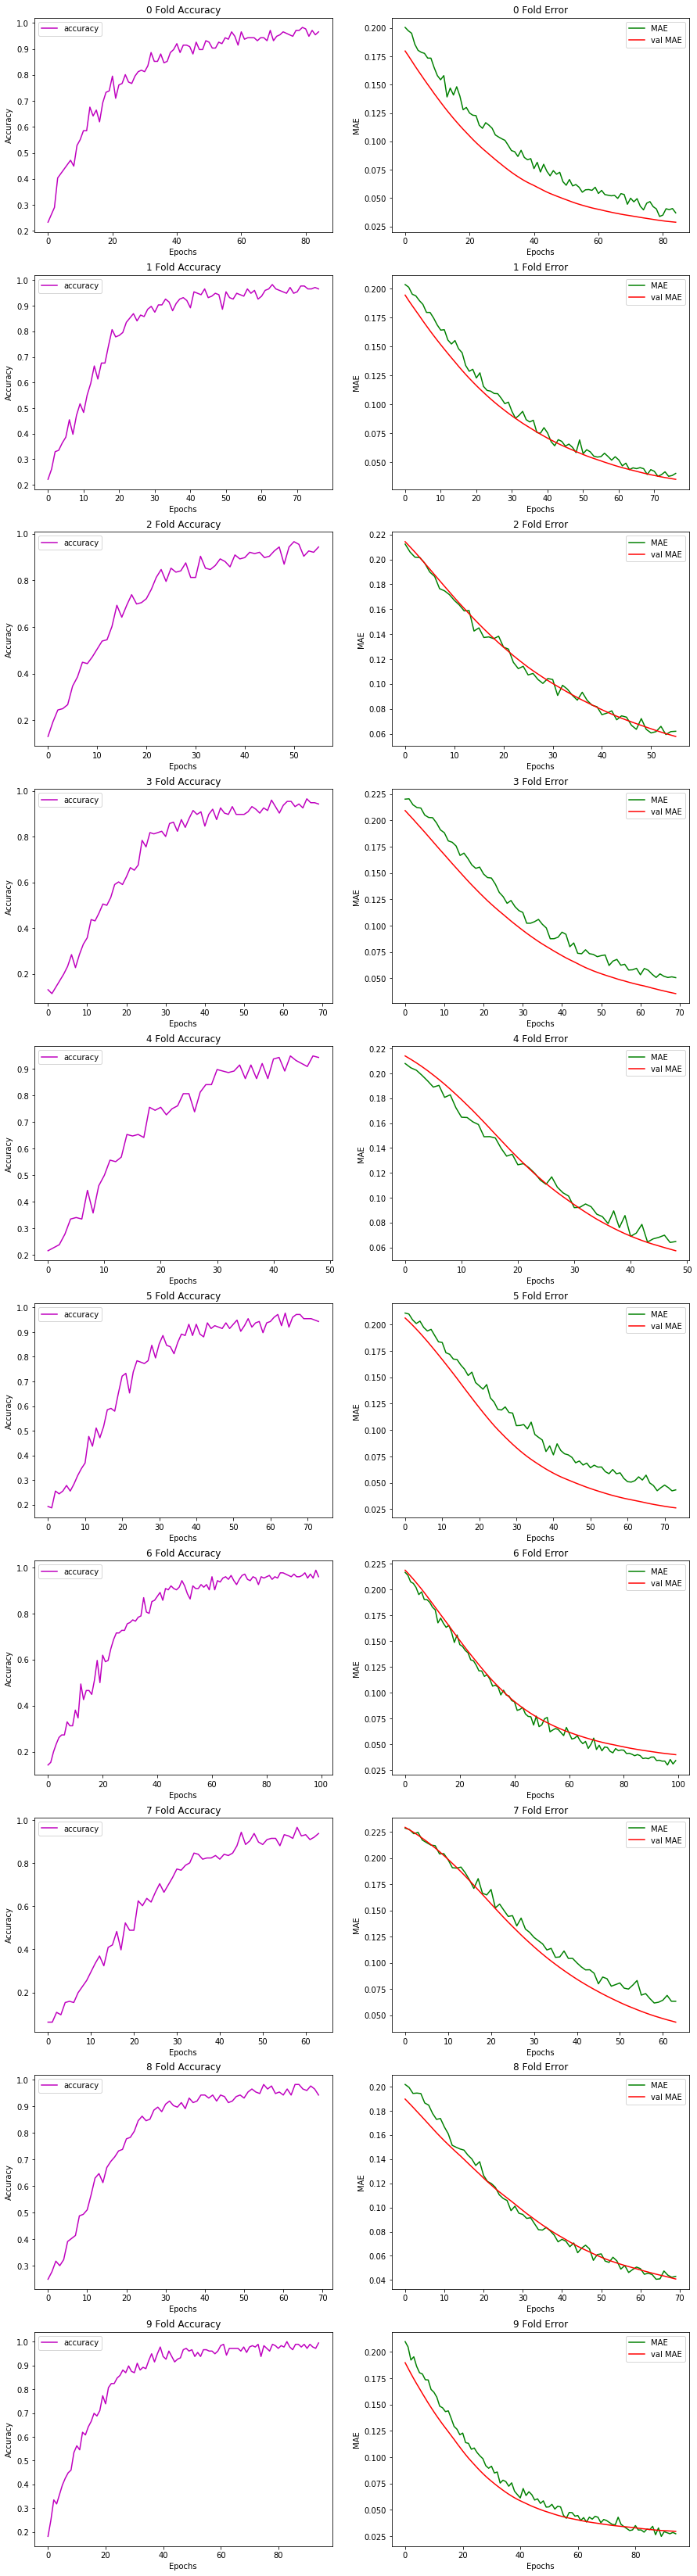

In [11]:
#PLOTTING LOSS AND ACCURACY GRAPHS AFTER TRAINING THE MODEL WITH K=10 FOLDS:
print('Cross validation''s acc and mae graphs')
import matplotlib.pyplot as plt
fig=plt.figure(figsize=(15,120))
for i in range(k):
    ax=fig.add_subplot(20,2,2*i+1)
    ax.plot(history[i].history['accuracy'],'m-',label='accuracy')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Accuracy')
    ax.legend()
    #ax.title(' Fold accuracy')
    ax.set_title(str(i)+' Fold Accuracy')
    
    ax2=fig.add_subplot(20,2,2*i+2)
    ax2.plot(history[i].history['mae'],'g-',label='MAE')
    ax2.plot(history[i].history['val_mae'],'r-',label='val MAE')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('MAE')
    ax2.legend()
    ax2.set_title(str(i)+' Fold Error')
    #axs[1, 0].set_title('Axis [1, 0]')


In [5]:
#taskbrain.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['accuracy'])
#history=taskbrain.fit(GENTEXT,y_np,batch_size=10,epochs=100)




####SAVE:
#taskbrain.save('beauty.h5')
#np.save('w2v',word2vec.get_weights()[0])
###LOAD:
'''import tensorflow_hub as hub
taskbrain=models.load_model('beauty.h5',custom_objects={'KerasLayer':hub.KerasLayer})
pretrained_model='word2vec'
word2vec=hub.KerasLayer(pretrained_model,input_shape=[],dtype=tf.string,trainable=True)
f=open('w2v.npy','rb')
word2vec.set_weights([np.load(f)])'''

In [148]:
#model7=allmodels[4]
#model7 = model.save('newmodelacc88.h5')
model7=tf.keras.models.load_model('newmodelacc95.h5',custom_objects={'KerasLayer':hub.KerasLayer})

# STEP 5: Testing and scoring
---
**Agenda:**

In [149]:

y_pred=model7.predict(x_test)
for i in range(0,len(y_pred)):
    mval=max(y_pred[i]);
    for j in range(0,8):
        if (y_pred[i][j]==mval):
            y_pred[i][j]=1
        else:
            y_pred[i][j]=0
y_test


array([[0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 1., 

In [82]:
y_pred

array([[0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1.],
       [1., 0., 

In [150]:
ytest=np.zeros(len(y_test),dtype=int)
ypred=np.zeros(len(y_test),dtype=int)
for i in range(0,len(y_test)):
    for j in range(0,8):
        if (y_test[i][j]==1):
            ytest[i]=j+1
            break

for i in range(0,len(y_test)):
    for j in range(0,8):
        if (y_pred[i][j]==1):
            ypred[i]=j+1
            break
ypred

array([6, 6, 1, 2, 8, 4, 6, 1, 5, 2, 8, 3, 2, 2, 5, 3, 8, 5, 3, 3, 5, 5,
       7, 8, 2, 6, 1, 6, 3, 4, 3, 3, 6, 7, 6, 3, 7, 1, 7, 6, 6, 7, 6, 4,
       7, 6, 8, 6, 7, 2, 3, 4, 1, 7, 8, 2, 7, 6, 1, 5, 6, 2, 5, 7, 8, 6,
       8, 6, 5, 3, 6, 6, 3, 1, 2, 8, 6, 5, 8, 3, 5, 2, 3, 7, 3, 4, 8, 5,
       7, 6, 4, 5, 7, 1, 7, 1, 3, 2, 4, 2, 7])

In [151]:
ytest

array([6, 6, 1, 2, 7, 4, 6, 1, 5, 2, 7, 3, 2, 2, 5, 3, 7, 5, 3, 3, 5, 5,
       7, 8, 2, 6, 1, 6, 3, 4, 3, 7, 6, 7, 6, 3, 7, 1, 7, 6, 6, 7, 6, 4,
       7, 6, 8, 6, 7, 2, 3, 4, 1, 7, 8, 2, 7, 6, 1, 5, 6, 2, 5, 7, 8, 6,
       7, 6, 5, 3, 6, 6, 3, 1, 2, 8, 6, 5, 8, 3, 5, 2, 3, 7, 3, 4, 8, 5,
       7, 6, 4, 5, 7, 1, 7, 1, 3, 2, 4, 2, 7])

In [152]:
from sklearn.metrics import confusion_matrix
confusion_matrix(ytest, ypred)

array([[ 9,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 12,  0,  0,  0,  0,  0,  0],
       [ 0,  0, 14,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  7,  0,  0,  0,  0],
       [ 0,  0,  0,  0, 12,  0,  0,  0],
       [ 0,  0,  0,  0,  0, 20,  0,  0],
       [ 0,  0,  1,  0,  0,  0, 15,  4],
       [ 0,  0,  0,  0,  0,  0,  0,  7]], dtype=int64)

In [153]:
from sklearn.metrics import f1_score
f1_score(ytest, ypred, average='weighted')

0.9515301283822964

In [154]:
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_score
precision_score(ytest, ypred, average='weighted')

0.9655565556555655

In [155]:
recall_score(ytest, ypred,average='weighted')

0.9504950495049505

In [156]:
accuracy_score(ytest, ypred)

0.9504950495049505

In [157]:
raw=pd.read_csv('newdataset.csv')

In [144]:
#ENUMERATE TRIGGER STRINGS TO NUMBERS
dicto={}
count=0
y_np=[]
for i in raw.Trigger:
    if i in dicto.keys():
        y_np.append(dicto[i])
    else:
        dicto[i]=count
        count+=1
        y_np.append(dicto[i])
revdicto={}
for i in dicto.keys():
    revdicto[dicto[i]]=i;
#print('Trigger enumeration results: ',y_np)   

In [145]:
def aggressive_fermenterv2(s):
    
        
    s=s.lower()
    stopwords=[" the"," is"," and"," get"," to"," please"]
    for stopper in stopwords:
        s=s.replace(stopper,'')
    replace_rules=[["ness",""],["you"," "],["i am"," "],["es","e"],["sses","ss"],["ies","y"],["s",""],[","," "]]

    for rule in range(len(replace_rules)):
        regstring=replace_rules[rule][0]+r"\s+"
        endreg=replace_rules[rule][0]+r"$"
        s=re.sub(regstring,replace_rules[rule][1]+" ",s)
        s=re.sub(endreg,replace_rules[rule][1]+" ",s)
        
    
    s=re.sub(r"\s\s"," ",s)
    s=re.sub(r"^\s","",s)
    s=re.sub(r"\s$","",s)
    return s

GENTEXT=[]
pristine=[]
for sentence in raw.String:
    GENTEXT.append(aggressive_fermenterv2(sentence))
    
tfidf=TfidfVectorizer(min_df=1,norm=None,smooth_idf=False, ngram_range=(1, 2))
features=tfidf.fit_transform(GENTEXT)
pristine=pd.DataFrame(
features.todense(),
columns=tfidf.get_feature_names())
x_mat=pristine.to_numpy()
for i in range(len(pristine)):
    for j in range(len(pristine.iloc[i])):
        if(pristine.iloc[i,j]!=0):
            pristine.iloc[i,j]=1
pristine      

,activate,activate fan,air,air in,air out,all,all door,all entrie,answer,answer door,...,will,will latch,will safeguard,will seal,wind,wind up,window,would,would slam,zero
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
497,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
498,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
499,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [146]:
x_np=pristine.to_numpy()
y_np=np.array(y_np)
import numpy as np
nb_classes = 8
data = y_np

def indices_to_one_hot(data, nb_classes):
    """Convert an iterable of indices to one-hot encoded labels."""
    targets = np.array(data).reshape(-1)
    return np.eye(nb_classes)[targets]

yal=indices_to_one_hot(data,8)
yal

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [147]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_np, yal,test_size=0.20, random_state=1)
x_train.shape,y_train.shape,x_test.shape,y_test.shape

((401, 444), (401, 8), (101, 444), (101, 8))

In [7]:
#model without Word2vec
def new_model():
    taskbrain=models.Sequential()
    taskbrain.add(layers.Dense(32, activation="relu", input_shape=(444,)))
    taskbrain.add(layers.Dense(32))
    taskbrain.add(Dropout(0.2))
    taskbrain.add(layers.Dense(64))
    taskbrain.add(Dropout(0.4))
    taskbrain.add(layers.Dense(8,activation='softmax'))
    taskbrain.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['accuracy','mae','mse'])
    return taskbrain

In [8]:
from keras.callbacks import EarlyStopping
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
k=10
print('training in progress:...\n\n')
num_val_samples = len(x_train) // k
num_epochs = 100
all_scores = []
all_acc=[]
allmodels=[]
history=[]
for i in range(k):
    print('\nprocessing fold #', i)
    val_data = x_train[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = y_train[i * num_val_samples: (i + 1) * num_val_samples]
    partial_x_train = np.concatenate(
        [x_train[:i * num_val_samples],
        x_train[(i + 1) * num_val_samples:]],
        axis=0)
    partial_y_train = np.concatenate(
        [y_train[:i * num_val_samples],
        y_train[(i + 1) * num_val_samples:]],
        axis=0)
    model = new_model()
    cur_history=model.fit(partial_x_train, partial_y_train, epochs=num_epochs, batch_size=64, validation_data=(val_data,val_targets),callbacks=[callback]);
    loss,acc,mae,mse=model.evaluate(val_data, val_targets)
    allmodels.append(model);
    history.append(cur_history)
    all_scores.append(mae)
    all_acc.append(acc)
    print('='*100)

training in progress:...



processing fold # 0
Epoch 1/100
6/6 [==============================] - 0s 72ms/step - loss: 2.0714 - accuracy: 0.1108 - mae: 0.2181 - mse: 0.1091 - val_loss: 2.0490 - val_accuracy: 0.1750 - val_mae: 0.2176 - val_mse: 0.1085
Epoch 2/100
6/6 [==============================] - 0s 5ms/step - loss: 2.0059 - accuracy: 0.2271 - mae: 0.2159 - mse: 0.1070 - val_loss: 2.0040 - val_accuracy: 0.2500 - val_mae: 0.2160 - val_mse: 0.1070
Epoch 3/100
6/6 [==============================] - 0s 5ms/step - loss: 1.9443 - accuracy: 0.3186 - mae: 0.2135 - mse: 0.1049 - val_loss: 1.9535 - val_accuracy: 0.2500 - val_mae: 0.2141 - val_mse: 0.1053
Epoch 4/100
6/6 [==============================] - 0s 6ms/step - loss: 1.8621 - accuracy: 0.4072 - mae: 0.2100 - mse: 0.1017 - val_loss: 1.8911 - val_accuracy: 0.3250 - val_mae: 0.2116 - val_mse: 0.1030
Epoch 5/100
6/6 [==============================] - 0s 12ms/step - loss: 1.7879 - accuracy: 0.4792 - mae: 0.2063 - mse: 0.0987 - val_loss: 1

Epoch 41/100
6/6 [==============================] - 0s 6ms/step - loss: 0.0060 - accuracy: 1.0000 - mae: 0.0014 - mse: 1.2403e-04 - val_loss: 0.2269 - val_accuracy: 0.9250 - val_mae: 0.0193 - val_mse: 0.0148
Epoch 42/100
6/6 [==============================] - 0s 6ms/step - loss: 0.0056 - accuracy: 1.0000 - mae: 0.0013 - mse: 9.0323e-05 - val_loss: 0.2359 - val_accuracy: 0.9250 - val_mae: 0.0190 - val_mse: 0.0149
Epoch 43/100
6/6 [==============================] - 0s 6ms/step - loss: 0.0031 - accuracy: 1.0000 - mae: 7.5529e-04 - mse: 3.4012e-05 - val_loss: 0.2383 - val_accuracy: 0.9250 - val_mae: 0.0190 - val_mse: 0.0151
Epoch 44/100
6/6 [==============================] - 0s 9ms/step - loss: 0.0037 - accuracy: 1.0000 - mae: 9.1517e-04 - mse: 3.0211e-05 - val_loss: 0.2335 - val_accuracy: 0.9250 - val_mae: 0.0187 - val_mse: 0.0149
Epoch 45/100
6/6 [==============================] - 0s 9ms/step - loss: 0.0041 - accuracy: 1.0000 - mae: 9.5075e-04 - mse: 1.1847e-04 - val_loss: 0.2432 - val_a

Epoch 13/100
6/6 [==============================] - 0s 4ms/step - loss: 0.7983 - accuracy: 0.8920 - mae: 0.1268 - mse: 0.0463 - val_loss: 0.7687 - val_accuracy: 0.9750 - val_mae: 0.1261 - val_mse: 0.0446
Epoch 14/100
6/6 [==============================] - 0s 4ms/step - loss: 0.6745 - accuracy: 0.9363 - mae: 0.1123 - mse: 0.0385 - val_loss: 0.6559 - val_accuracy: 0.9750 - val_mae: 0.1125 - val_mse: 0.0373
Epoch 15/100
6/6 [==============================] - 0s 4ms/step - loss: 0.5770 - accuracy: 0.9446 - mae: 0.1000 - mse: 0.0323 - val_loss: 0.5518 - val_accuracy: 0.9750 - val_mae: 0.0987 - val_mse: 0.0305
Epoch 16/100
6/6 [==============================] - 0s 4ms/step - loss: 0.5135 - accuracy: 0.9391 - mae: 0.0904 - mse: 0.0287 - val_loss: 0.4612 - val_accuracy: 0.9750 - val_mae: 0.0856 - val_mse: 0.0245
Epoch 17/100
6/6 [==============================] - 0s 5ms/step - loss: 0.4256 - accuracy: 0.9529 - mae: 0.0782 - mse: 0.0228 - val_loss: 0.3827 - val_accuracy: 1.0000 - val_mae: 0.073

6/6 [==============================] - 0s 4ms/step - loss: 0.0023 - accuracy: 1.0000 - mae: 5.7049e-04 - mse: 2.4687e-05 - val_loss: 0.0034 - val_accuracy: 1.0000 - val_mae: 8.1304e-04 - val_mse: 4.6533e-05
Epoch 53/100
6/6 [==============================] - 0s 4ms/step - loss: 0.0012 - accuracy: 1.0000 - mae: 2.9333e-04 - mse: 4.9222e-06 - val_loss: 0.0030 - val_accuracy: 1.0000 - val_mae: 7.2217e-04 - val_mse: 3.6846e-05
Epoch 54/100
6/6 [==============================] - 0s 4ms/step - loss: 0.0013 - accuracy: 1.0000 - mae: 3.3196e-04 - mse: 8.2571e-06 - val_loss: 0.0034 - val_accuracy: 1.0000 - val_mae: 8.2167e-04 - val_mse: 4.9122e-05
Epoch 55/100
6/6 [==============================] - 0s 4ms/step - loss: 0.0014 - accuracy: 1.0000 - mae: 3.4537e-04 - mse: 2.8536e-05 - val_loss: 0.0061 - val_accuracy: 1.0000 - val_mae: 0.0014 - val_mse: 1.5491e-04
Epoch 56/100
6/6 [==============================] - 0s 4ms/step - loss: 8.2682e-04 - accuracy: 1.0000 - mae: 2.0468e-04 - mse: 3.3923e-06

Epoch 25/100
6/6 [==============================] - 0s 5ms/step - loss: 0.1427 - accuracy: 0.9917 - mae: 0.0300 - mse: 0.0064 - val_loss: 0.2660 - val_accuracy: 0.8750 - val_mae: 0.0458 - val_mse: 0.0176
Epoch 26/100
6/6 [==============================] - 0s 5ms/step - loss: 0.1256 - accuracy: 0.9972 - mae: 0.0264 - mse: 0.0055 - val_loss: 0.2488 - val_accuracy: 0.8750 - val_mae: 0.0422 - val_mse: 0.0171
Epoch 27/100
6/6 [==============================] - 0s 5ms/step - loss: 0.1121 - accuracy: 0.9889 - mae: 0.0234 - mse: 0.0049 - val_loss: 0.2350 - val_accuracy: 0.8500 - val_mae: 0.0395 - val_mse: 0.0166
Epoch 28/100
6/6 [==============================] - 0s 4ms/step - loss: 0.0879 - accuracy: 0.9972 - mae: 0.0190 - mse: 0.0034 - val_loss: 0.2131 - val_accuracy: 0.8750 - val_mae: 0.0365 - val_mse: 0.0156
Epoch 29/100
6/6 [==============================] - 0s 5ms/step - loss: 0.0775 - accuracy: 0.9917 - mae: 0.0168 - mse: 0.0031 - val_loss: 0.2092 - val_accuracy: 0.8750 - val_mae: 0.034

6/6 [==============================] - 0s 4ms/step - loss: 0.0014 - accuracy: 1.0000 - mae: 3.3058e-04 - mse: 2.5240e-05 - val_loss: 0.3381 - val_accuracy: 0.9000 - val_mae: 0.0253 - val_mse: 0.0230
Epoch 65/100
6/6 [==============================] - 0s 4ms/step - loss: 9.5629e-04 - accuracy: 1.0000 - mae: 2.3706e-04 - mse: 3.7194e-06 - val_loss: 0.3437 - val_accuracy: 0.9000 - val_mae: 0.0252 - val_mse: 0.0231
Epoch 66/100
6/6 [==============================] - 0s 5ms/step - loss: 8.4295e-04 - accuracy: 1.0000 - mae: 2.0781e-04 - mse: 4.6985e-06 - val_loss: 0.3388 - val_accuracy: 0.9000 - val_mae: 0.0251 - val_mse: 0.0231
Epoch 67/100
6/6 [==============================] - 0s 5ms/step - loss: 9.2188e-04 - accuracy: 1.0000 - mae: 2.2714e-04 - mse: 5.8417e-06 - val_loss: 0.3201 - val_accuracy: 0.9000 - val_mae: 0.0250 - val_mse: 0.0227
Epoch 68/100
6/6 [==============================] - 0s 5ms/step - loss: 0.0013 - accuracy: 1.0000 - mae: 3.0892e-04 - mse: 1.0531e-05 - val_loss: 0.3512 

6/6 [==============================] - 0s 4ms/step - loss: 0.2630 - accuracy: 0.9834 - mae: 0.0518 - mse: 0.0137 - val_loss: 0.4349 - val_accuracy: 0.8750 - val_mae: 0.0661 - val_mse: 0.0265
Epoch 22/100
6/6 [==============================] - 0s 4ms/step - loss: 0.2135 - accuracy: 0.9861 - mae: 0.0434 - mse: 0.0103 - val_loss: 0.4003 - val_accuracy: 0.9000 - val_mae: 0.0590 - val_mse: 0.0243
Epoch 23/100
6/6 [==============================] - 0s 4ms/step - loss: 0.2018 - accuracy: 0.9695 - mae: 0.0399 - mse: 0.0102 - val_loss: 0.3895 - val_accuracy: 0.9000 - val_mae: 0.0543 - val_mse: 0.0237
Epoch 24/100
6/6 [==============================] - ETA: 0s - loss: 0.1643 - accuracy: 0.9688 - mae: 0.0334 - mse: 0.00 - 0s 4ms/step - loss: 0.1617 - accuracy: 0.9806 - mae: 0.0328 - mse: 0.0078 - val_loss: 0.3727 - val_accuracy: 0.9000 - val_mae: 0.0503 - val_mse: 0.0234
Epoch 25/100
6/6 [==============================] - 0s 4ms/step - loss: 0.1371 - accuracy: 0.9972 - mae: 0.0289 - mse: 0.0058 -

6/6 [==============================] - 0s 4ms/step - loss: 0.0015 - accuracy: 1.0000 - mae: 3.6201e-04 - mse: 8.8931e-06 - val_loss: 0.5832 - val_accuracy: 0.9000 - val_mae: 0.0260 - val_mse: 0.0241
Epoch 61/100
6/6 [==============================] - 0s 5ms/step - loss: 0.0013 - accuracy: 1.0000 - mae: 3.1404e-04 - mse: 4.8907e-06 - val_loss: 0.5540 - val_accuracy: 0.9000 - val_mae: 0.0255 - val_mse: 0.0236
Epoch 62/100
6/6 [==============================] - 0s 5ms/step - loss: 9.4942e-04 - accuracy: 1.0000 - mae: 2.3487e-04 - mse: 4.4148e-06 - val_loss: 0.5778 - val_accuracy: 0.9000 - val_mae: 0.0261 - val_mse: 0.0241
Epoch 63/100
6/6 [==============================] - 0s 5ms/step - loss: 0.0011 - accuracy: 1.0000 - mae: 2.6771e-04 - mse: 8.7902e-06 - val_loss: 0.5837 - val_accuracy: 0.9000 - val_mae: 0.0253 - val_mse: 0.0237
Epoch 64/100
6/6 [==============================] - 0s 6ms/step - loss: 6.5629e-04 - accuracy: 1.0000 - mae: 1.6272e-04 - mse: 2.2345e-06 - val_loss: 0.5752 - va

Epoch 30/100
6/6 [==============================] - 0s 5ms/step - loss: 0.0464 - accuracy: 0.9972 - mae: 0.0095 - mse: 0.0017 - val_loss: 0.1074 - val_accuracy: 0.9500 - val_mae: 0.0158 - val_mse: 0.0064
Epoch 31/100
6/6 [==============================] - 0s 4ms/step - loss: 0.0319 - accuracy: 1.0000 - mae: 0.0074 - mse: 7.1299e-04 - val_loss: 0.1057 - val_accuracy: 0.9500 - val_mae: 0.0148 - val_mse: 0.0068
Epoch 32/100
6/6 [==============================] - 0s 5ms/step - loss: 0.0303 - accuracy: 0.9972 - mae: 0.0068 - mse: 9.2791e-04 - val_loss: 0.0973 - val_accuracy: 0.9500 - val_mae: 0.0139 - val_mse: 0.0064
Epoch 33/100
6/6 [==============================] - 0s 4ms/step - loss: 0.0230 - accuracy: 1.0000 - mae: 0.0052 - mse: 6.3722e-04 - val_loss: 0.1013 - val_accuracy: 0.9500 - val_mae: 0.0134 - val_mse: 0.0070
Epoch 34/100
6/6 [==============================] - 0s 5ms/step - loss: 0.0226 - accuracy: 1.0000 - mae: 0.0051 - mse: 6.6457e-04 - val_loss: 0.0998 - val_accuracy: 0.9500 

Epoch 69/100
6/6 [==============================] - 0s 4ms/step - loss: 0.0011 - accuracy: 1.0000 - mae: 2.7204e-04 - mse: 2.0811e-05 - val_loss: 0.0743 - val_accuracy: 0.9500 - val_mae: 0.0094 - val_mse: 0.0068
Epoch 70/100
6/6 [==============================] - 0s 4ms/step - loss: 5.1399e-04 - accuracy: 1.0000 - mae: 1.2689e-04 - mse: 2.5675e-06 - val_loss: 0.0753 - val_accuracy: 0.9500 - val_mae: 0.0097 - val_mse: 0.0071
Epoch 71/100
6/6 [==============================] - 0s 4ms/step - loss: 3.2977e-04 - accuracy: 1.0000 - mae: 8.1568e-05 - mse: 1.6724e-06 - val_loss: 0.0723 - val_accuracy: 0.9500 - val_mae: 0.0096 - val_mse: 0.0067
Epoch 72/100
6/6 [==============================] - 0s 4ms/step - loss: 4.5662e-04 - accuracy: 1.0000 - mae: 1.1315e-04 - mse: 1.6608e-06 - val_loss: 0.0749 - val_accuracy: 0.9500 - val_mae: 0.0097 - val_mse: 0.0070
Epoch 73/100
6/6 [==============================] - 0s 5ms/step - loss: 2.9985e-04 - accuracy: 1.0000 - mae: 7.4498e-05 - mse: 7.0178e-07 - 

Epoch 20/100
6/6 [==============================] - 0s 6ms/step - loss: 0.2539 - accuracy: 0.9834 - mae: 0.0495 - mse: 0.0127 - val_loss: 0.3234 - val_accuracy: 0.9750 - val_mae: 0.0594 - val_mse: 0.0159
Epoch 21/100
6/6 [==============================] - 0s 6ms/step - loss: 0.2138 - accuracy: 0.9834 - mae: 0.0423 - mse: 0.0105 - val_loss: 0.2826 - val_accuracy: 0.9750 - val_mae: 0.0528 - val_mse: 0.0135
Epoch 22/100
6/6 [==============================] - 0s 6ms/step - loss: 0.1735 - accuracy: 0.9889 - mae: 0.0350 - mse: 0.0079 - val_loss: 0.2443 - val_accuracy: 0.9750 - val_mae: 0.0460 - val_mse: 0.0115
Epoch 23/100
6/6 [==============================] - 0s 6ms/step - loss: 0.1526 - accuracy: 0.9945 - mae: 0.0314 - mse: 0.0067 - val_loss: 0.2112 - val_accuracy: 0.9750 - val_mae: 0.0399 - val_mse: 0.0099
Epoch 24/100
6/6 [==============================] - 0s 5ms/step - loss: 0.1128 - accuracy: 0.9945 - mae: 0.0244 - mse: 0.0043 - val_loss: 0.1860 - val_accuracy: 0.9750 - val_mae: 0.035

6/6 [==============================] - 0s 8ms/step - loss: 0.0012 - accuracy: 1.0000 - mae: 2.9798e-04 - mse: 1.1681e-05 - val_loss: 0.0984 - val_accuracy: 0.9750 - val_mae: 0.0069 - val_mse: 0.0058
Epoch 60/100
6/6 [==============================] - 0s 7ms/step - loss: 0.0010 - accuracy: 1.0000 - mae: 2.5269e-04 - mse: 1.1783e-05 - val_loss: 0.0853 - val_accuracy: 0.9750 - val_mae: 0.0067 - val_mse: 0.0055
Epoch 61/100
6/6 [==============================] - 0s 11ms/step - loss: 7.9734e-04 - accuracy: 1.0000 - mae: 1.9530e-04 - mse: 7.3651e-06 - val_loss: 0.0899 - val_accuracy: 0.9750 - val_mae: 0.0067 - val_mse: 0.0056
Epoch 62/100
6/6 [==============================] - 0s 10ms/step - loss: 0.0010 - accuracy: 1.0000 - mae: 2.5646e-04 - mse: 6.4208e-06 - val_loss: 0.1078 - val_accuracy: 0.9750 - val_mae: 0.0067 - val_mse: 0.0058
Epoch 63/100
6/6 [==============================] - 0s 10ms/step - loss: 8.2248e-04 - accuracy: 1.0000 - mae: 2.0055e-04 - mse: 9.0437e-06 - val_loss: 0.1298 -

6/6 [==============================] - 0s 6ms/step - loss: 0.3280 - accuracy: 0.9557 - mae: 0.0609 - mse: 0.0173 - val_loss: 0.2755 - val_accuracy: 0.9750 - val_mae: 0.0535 - val_mse: 0.0139
Epoch 21/100
6/6 [==============================] - 0s 5ms/step - loss: 0.2677 - accuracy: 0.9806 - mae: 0.0511 - mse: 0.0134 - val_loss: 0.2337 - val_accuracy: 0.9750 - val_mae: 0.0464 - val_mse: 0.0114
Epoch 22/100
6/6 [==============================] - 0s 5ms/step - loss: 0.2285 - accuracy: 0.9917 - mae: 0.0445 - mse: 0.0110 - val_loss: 0.2001 - val_accuracy: 0.9750 - val_mae: 0.0402 - val_mse: 0.0096
Epoch 23/100
6/6 [==============================] - 0s 5ms/step - loss: 0.1892 - accuracy: 0.9861 - mae: 0.0372 - mse: 0.0089 - val_loss: 0.1708 - val_accuracy: 0.9750 - val_mae: 0.0351 - val_mse: 0.0078
Epoch 24/100
6/6 [==============================] - 0s 5ms/step - loss: 0.1571 - accuracy: 0.9945 - mae: 0.0320 - mse: 0.0070 - val_loss: 0.1490 - val_accuracy: 0.9750 - val_mae: 0.0310 - val_mse: 

Epoch 59/100
6/6 [==============================] - 0s 6ms/step - loss: 0.0013 - accuracy: 1.0000 - mae: 3.1549e-04 - mse: 9.2010e-06 - val_loss: 0.0035 - val_accuracy: 1.0000 - val_mae: 8.5578e-04 - val_mse: 3.7576e-05
Epoch 60/100
6/6 [==============================] - 0s 5ms/step - loss: 7.1154e-04 - accuracy: 1.0000 - mae: 1.7662e-04 - mse: 2.0792e-06 - val_loss: 0.0030 - val_accuracy: 1.0000 - val_mae: 7.4166e-04 - val_mse: 2.7836e-05
Epoch 61/100
6/6 [==============================] - 0s 6ms/step - loss: 7.1426e-04 - accuracy: 1.0000 - mae: 1.7689e-04 - mse: 2.9023e-06 - val_loss: 0.0028 - val_accuracy: 1.0000 - val_mae: 6.7801e-04 - val_mse: 2.5209e-05
Epoch 62/100
6/6 [==============================] - 0s 5ms/step - loss: 5.0994e-04 - accuracy: 1.0000 - mae: 1.2664e-04 - mse: 1.3687e-06 - val_loss: 0.0026 - val_accuracy: 1.0000 - val_mae: 6.2364e-04 - val_mse: 2.1811e-05
Epoch 63/100
6/6 [==============================] - 0s 5ms/step - loss: 7.5188e-04 - accuracy: 1.0000 - mae:

6/6 [==============================] - 0s 6ms/step - loss: 1.8502e-04 - accuracy: 1.0000 - mae: 4.5766e-05 - mse: 9.2199e-07 - val_loss: 5.3336e-04 - val_accuracy: 1.0000 - val_mae: 1.3266e-04 - val_mse: 1.1844e-06
Epoch 96/100
6/6 [==============================] - 0s 5ms/step - loss: 1.3473e-04 - accuracy: 1.0000 - mae: 3.3492e-05 - mse: 3.7401e-07 - val_loss: 4.3651e-04 - val_accuracy: 1.0000 - val_mae: 1.0868e-04 - val_mse: 7.9131e-07
Epoch 97/100
6/6 [==============================] - 0s 6ms/step - loss: 1.7123e-05 - accuracy: 1.0000 - mae: 4.2798e-06 - mse: 2.8115e-09 - val_loss: 4.3498e-04 - val_accuracy: 1.0000 - val_mae: 1.0830e-04 - val_mse: 8.1647e-07
Epoch 98/100
6/6 [==============================] - 0s 5ms/step - loss: 1.0600e-05 - accuracy: 1.0000 - mae: 2.6507e-06 - mse: 7.0154e-10 - val_loss: 3.9205e-04 - val_accuracy: 1.0000 - val_mae: 9.7655e-05 - val_mse: 6.4881e-07
Epoch 99/100
6/6 [==============================] - 0s 5ms/step - loss: 9.5284e-05 - accuracy: 1.0000

6/6 [==============================] - 0s 5ms/step - loss: 0.0215 - accuracy: 1.0000 - mae: 0.0050 - mse: 4.9059e-04 - val_loss: 0.0711 - val_accuracy: 0.9750 - val_mae: 0.0129 - val_mse: 0.0042
Epoch 34/100
6/6 [==============================] - 0s 5ms/step - loss: 0.0226 - accuracy: 0.9972 - mae: 0.0051 - mse: 6.9398e-04 - val_loss: 0.0695 - val_accuracy: 0.9750 - val_mae: 0.0124 - val_mse: 0.0042
Epoch 35/100
6/6 [==============================] - 0s 5ms/step - loss: 0.0138 - accuracy: 1.0000 - mae: 0.0033 - mse: 1.8963e-04 - val_loss: 0.0659 - val_accuracy: 0.9750 - val_mae: 0.0117 - val_mse: 0.0041
Epoch 36/100
6/6 [==============================] - 0s 5ms/step - loss: 0.0154 - accuracy: 0.9972 - mae: 0.0035 - mse: 4.7475e-04 - val_loss: 0.0600 - val_accuracy: 1.0000 - val_mae: 0.0113 - val_mse: 0.0036
Epoch 37/100
6/6 [==============================] - 0s 5ms/step - loss: 0.0130 - accuracy: 1.0000 - mae: 0.0031 - mse: 2.5902e-04 - val_loss: 0.0576 - val_accuracy: 0.9750 - val_mae

Epoch 72/100
6/6 [==============================] - 0s 5ms/step - loss: 0.0013 - accuracy: 1.0000 - mae: 3.0107e-04 - mse: 3.6827e-05 - val_loss: 0.0394 - val_accuracy: 0.9750 - val_mae: 0.0073 - val_mse: 0.0029
Epoch 73/100
6/6 [==============================] - 0s 5ms/step - loss: 1.8669e-04 - accuracy: 1.0000 - mae: 4.6561e-05 - mse: 2.0677e-07 - val_loss: 0.0399 - val_accuracy: 0.9750 - val_mae: 0.0073 - val_mse: 0.0029
Epoch 74/100
6/6 [==============================] - 0s 6ms/step - loss: 4.0910e-04 - accuracy: 1.0000 - mae: 1.0059e-04 - mse: 2.7208e-06 - val_loss: 0.0525 - val_accuracy: 0.9750 - val_mae: 0.0081 - val_mse: 0.0044
Epoch 75/100
6/6 [==============================] - 0s 6ms/step - loss: 4.2472e-04 - accuracy: 1.0000 - mae: 1.0389e-04 - mse: 4.2136e-06 - val_loss: 0.0444 - val_accuracy: 0.9750 - val_mae: 0.0071 - val_mse: 0.0036
Epoch 76/100
2/2 [==============================] - 0s 3ms/step - loss: 0.0355 - accuracy: 0.9750 - mae: 0.0062 - mse: 0.0027

processing fo

Epoch 35/100
6/6 [==============================] - 0s 6ms/step - loss: 0.0163 - accuracy: 1.0000 - mae: 0.0037 - mse: 4.0615e-04 - val_loss: 0.3658 - val_accuracy: 0.9500 - val_mae: 0.0235 - val_mse: 0.0154
Epoch 36/100
6/6 [==============================] - 0s 6ms/step - loss: 0.0119 - accuracy: 1.0000 - mae: 0.0028 - mse: 1.7640e-04 - val_loss: 0.3897 - val_accuracy: 0.9500 - val_mae: 0.0230 - val_mse: 0.0157
Epoch 37/100
6/6 [==============================] - 0s 7ms/step - loss: 0.0107 - accuracy: 1.0000 - mae: 0.0024 - mse: 2.5894e-04 - val_loss: 0.3893 - val_accuracy: 0.9500 - val_mae: 0.0222 - val_mse: 0.0155
Epoch 38/100
6/6 [==============================] - 0s 6ms/step - loss: 0.0101 - accuracy: 1.0000 - mae: 0.0023 - mse: 2.3748e-04 - val_loss: 0.3960 - val_accuracy: 0.9500 - val_mae: 0.0199 - val_mse: 0.0140
Epoch 39/100
6/6 [==============================] - 0s 7ms/step - loss: 0.0082 - accuracy: 1.0000 - mae: 0.0019 - mse: 1.3627e-04 - val_loss: 0.4098 - val_accuracy: 0.9

6/6 [==============================] - 0s 13ms/step - loss: 1.7629 - accuracy: 0.5540 - mae: 0.2055 - mse: 0.0976 - val_loss: 1.7822 - val_accuracy: 0.5750 - val_mae: 0.2067 - val_mse: 0.0984
Epoch 6/100
6/6 [==============================] - 0s 10ms/step - loss: 1.6540 - accuracy: 0.5900 - mae: 0.1996 - mse: 0.0928 - val_loss: 1.6805 - val_accuracy: 0.6000 - val_mae: 0.2013 - val_mse: 0.0939
Epoch 7/100
6/6 [==============================] - 0s 5ms/step - loss: 1.5259 - accuracy: 0.6482 - mae: 0.1920 - mse: 0.0869 - val_loss: 1.5680 - val_accuracy: 0.6000 - val_mae: 0.1946 - val_mse: 0.0886
Epoch 8/100
6/6 [==============================] - 0s 5ms/step - loss: 1.4231 - accuracy: 0.6593 - mae: 0.1845 - mse: 0.0819 - val_loss: 1.4445 - val_accuracy: 0.6000 - val_mae: 0.1860 - val_mse: 0.0822
Epoch 9/100
6/6 [==============================] - 0s 5ms/step - loss: 1.2795 - accuracy: 0.7230 - mae: 0.1735 - mse: 0.0746 - val_loss: 1.3209 - val_accuracy: 0.6500 - val_mae: 0.1762 - val_mse: 0.

Epoch 45/100
6/6 [==============================] - 0s 5ms/step - loss: 0.0045 - accuracy: 1.0000 - mae: 0.0011 - mse: 6.8792e-05 - val_loss: 0.1553 - val_accuracy: 0.9000 - val_mae: 0.0194 - val_mse: 0.0128
Epoch 46/100
6/6 [==============================] - 0s 5ms/step - loss: 0.0037 - accuracy: 1.0000 - mae: 8.9019e-04 - mse: 7.1672e-05 - val_loss: 0.1518 - val_accuracy: 0.9000 - val_mae: 0.0192 - val_mse: 0.0127
Epoch 47/100
6/6 [==============================] - 0s 6ms/step - loss: 0.0026 - accuracy: 1.0000 - mae: 6.2223e-04 - mse: 3.2929e-05 - val_loss: 0.1503 - val_accuracy: 0.9000 - val_mae: 0.0192 - val_mse: 0.0129
Epoch 48/100
6/6 [==============================] - 0s 6ms/step - loss: 0.0036 - accuracy: 1.0000 - mae: 8.6365e-04 - mse: 3.8869e-05 - val_loss: 0.1462 - val_accuracy: 0.9250 - val_mae: 0.0185 - val_mse: 0.0123
Epoch 49/100
6/6 [==============================] - 0s 12ms/step - loss: 0.0015 - accuracy: 1.0000 - mae: 3.6978e-04 - mse: 5.7481e-06 - val_loss: 0.1418 - 

6/6 [==============================] - 0s 9ms/step - loss: 6.4158e-05 - accuracy: 1.0000 - mae: 1.6029e-05 - mse: 1.9817e-08 - val_loss: 0.1722 - val_accuracy: 0.9250 - val_mae: 0.0170 - val_mse: 0.0130
Epoch 84/100
6/6 [==============================] - 0s 9ms/step - loss: 5.6622e-05 - accuracy: 1.0000 - mae: 1.4138e-05 - mse: 3.2043e-08 - val_loss: 0.1823 - val_accuracy: 0.9250 - val_mae: 0.0175 - val_mse: 0.0136
Epoch 85/100
6/6 [==============================] - 0s 9ms/step - loss: 5.3449e-05 - accuracy: 1.0000 - mae: 1.3351e-05 - mse: 2.2252e-08 - val_loss: 0.1855 - val_accuracy: 0.9250 - val_mae: 0.0176 - val_mse: 0.0137
Epoch 86/100
6/6 [==============================] - 0s 8ms/step - loss: 4.2383e-04 - accuracy: 1.0000 - mae: 1.0205e-04 - mse: 7.1019e-06 - val_loss: 0.1992 - val_accuracy: 0.9250 - val_mae: 0.0166 - val_mse: 0.0131
Epoch 87/100
6/6 [==============================] - 0s 8ms/step - loss: 5.6891e-05 - accuracy: 1.0000 - mae: 1.4195e-05 - mse: 4.8426e-08 - val_loss:

In [160]:
model7=tf.keras.models.load_model('newmodelacc88.h5',custom_objects={'KerasLayer':hub.KerasLayer})

In [161]:
y_pred=model7.predict(x_test)
for i in range(0,len(y_pred)):
    mval=max(y_pred[i]);
    for j in range(0,8):
        if (y_pred[i][j]==mval):
            y_pred[i][j]=1
        else:
            y_pred[i][j]=0
y_pred

array([[0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1.],
       [1., 0., 

In [162]:
ytest=np.zeros(len(y_test),dtype=int)
ypred=np.zeros(len(y_test),dtype=int)
for i in range(0,len(y_test)):
    for j in range(0,8):
        if (y_test[i][j]==1):
            ytest[i]=j+1
            break

for i in range(0,len(y_test)):
    for j in range(0,8):
        if (y_pred[i][j]==1):
            ypred[i]=j+1
            break


In [163]:
ypred

array([6, 6, 1, 1, 8, 4, 6, 1, 5, 2, 8, 3, 2, 1, 5, 3, 8, 5, 3, 3, 5, 5,
       7, 8, 1, 6, 1, 6, 3, 4, 3, 3, 6, 7, 6, 3, 7, 1, 7, 6, 6, 7, 6, 4,
       7, 6, 8, 6, 7, 2, 3, 4, 1, 7, 7, 2, 7, 6, 1, 5, 6, 2, 5, 7, 7, 6,
       8, 6, 7, 3, 6, 6, 3, 1, 2, 8, 6, 5, 8, 3, 5, 2, 3, 7, 3, 4, 7, 5,
       7, 6, 4, 5, 7, 1, 7, 1, 3, 2, 4, 2, 7])

In [53]:
ytest

array([6, 6, 1, 2, 7, 4, 6, 1, 5, 2, 7, 3, 2, 2, 5, 3, 7, 5, 3, 3, 5, 5,
       7, 8, 2, 6, 1, 6, 3, 4, 3, 7, 6, 7, 6, 3, 7, 1, 7, 6, 6, 7, 6, 4,
       7, 6, 8, 6, 7, 2, 3, 4, 1, 7, 8, 2, 7, 6, 1, 5, 6, 2, 5, 7, 8, 6,
       7, 6, 5, 3, 6, 6, 3, 1, 2, 8, 6, 5, 8, 3, 5, 2, 3, 7, 3, 4, 8, 5,
       7, 6, 4, 5, 7, 1, 7, 1, 3, 2, 4, 2, 7])

In [164]:
from sklearn.metrics import confusion_matrix
confusion_matrix(ytest, ypred)

array([[ 9,  0,  0,  0,  0,  0,  0,  0],
       [ 3,  9,  0,  0,  0,  0,  0,  0],
       [ 0,  0, 14,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  7,  0,  0,  0,  0],
       [ 0,  0,  0,  0, 11,  0,  1,  0],
       [ 0,  0,  0,  0,  0, 20,  0,  0],
       [ 0,  0,  1,  0,  0,  0, 15,  4],
       [ 0,  0,  0,  0,  0,  0,  3,  4]], dtype=int64)

In [165]:
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_score
precision_score(ytest, ypred, average='weighted')

0.8921400034740316

In [166]:
classification_report(ytest, ypred)

'             precision    recall  f1-score   support\n\n          1       0.75      1.00      0.86         9\n          2       1.00      0.75      0.86        12\n          3       0.93      1.00      0.97        14\n          4       1.00      1.00      1.00         7\n          5       1.00      0.92      0.96        12\n          6       1.00      1.00      1.00        20\n          7       0.79      0.75      0.77        20\n          8       0.50      0.57      0.53         7\n\navg / total       0.89      0.88      0.88       101\n'

In [167]:
accuracy_score(ytest, ypred)

0.8811881188118812

In [168]:
from sklearn.metrics import f1_score
f1_score(ytest, ypred, average='weighted')

0.8823113957111316

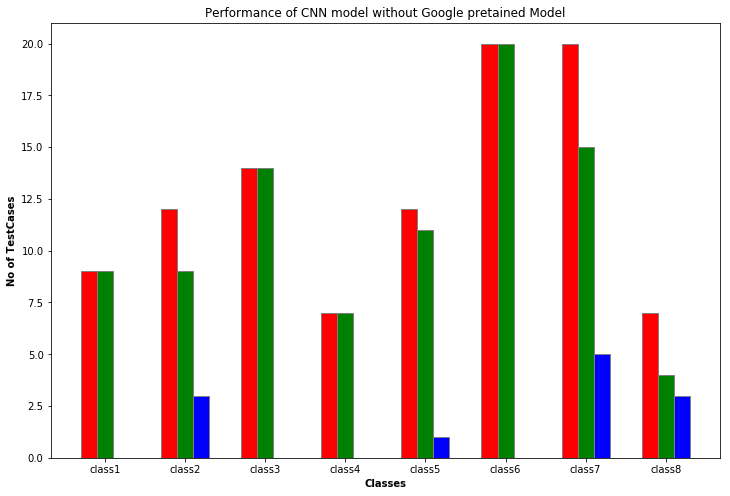

In [178]:
import matplotlib.pyplot as plt 
   
# set width of bar 
barWidth = 0.2
fig = plt.subplots(figsize =(12, 8)) 
   
# set height of bar 
correct = [9, 9, 14, 7,11,20,15,4] 
wrong = [0,3,0,0,1,0,5,3] 
total = [9,12,14,7,12,20,20,7]
   
# Set position of bar on X axis 
br1 = np.arange(8) 
br2 = [x + barWidth for x in br1] 
br3 = [x + barWidth for x in br2] 
   
# Make the plot 
plt.title('Performance of CNN model without Google pretained Model') 
plt.bar(br1, total, color ='r', width = barWidth, edgecolor ='grey', label ='Total') 
plt.bar(br2, correct, color ='g', width = barWidth, edgecolor ='grey', label ='Correctly predicted') 
plt.bar(br3, wrong, color ='b', width = barWidth,  edgecolor ='grey', label ='wrongly predicted') 

   
# Adding Xticks  
plt.xlabel('Classes', fontweight ='bold') 
plt.ylabel('No of TestCases', fontweight ='bold') 
plt.xticks([r + barWidth for r in range(len(IT))], 
           ['class1', 'class2', 'class3', 'class4', 'class5', 'class6','class7','class8']) 
   
plt.show() 

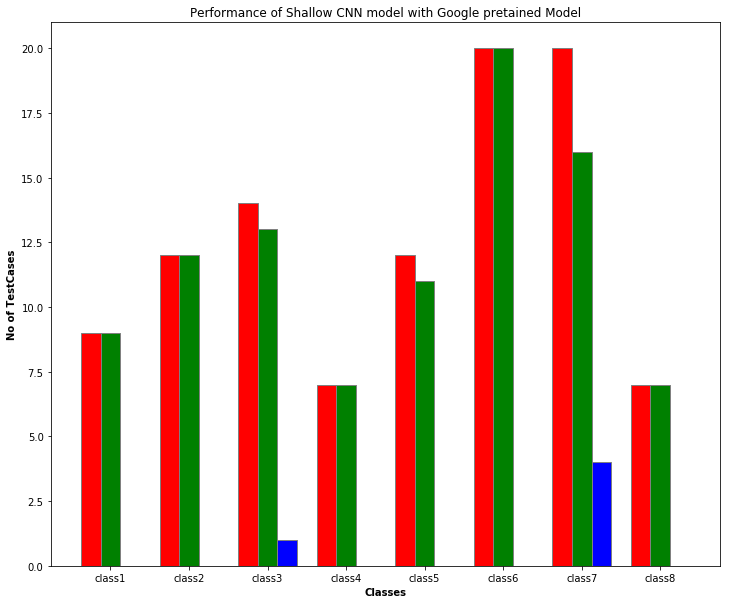

In [176]:
import matplotlib.pyplot as plt 
   
# set width of bar 
barWidth = 0.25
fig = plt.subplots(figsize =(12, 10)) 
   
# set height of bar 
correct = [9, 12, 13, 7,11,20,16,7] 
wrong = [0,0,1,0,0,0,4,0] 
total = [9,12,14,7,12,20,20,7]
   
# Set position of bar on X axis 
br1 = np.arange(8) 
br2 = [x + barWidth for x in br1] 
br3 = [x + barWidth for x in br2] 
   
# Make the plot 
plt.title('Performance of Shallow CNN model with Google pretained Model') 
plt.bar(br1, total, color ='r', width = barWidth, edgecolor ='grey', label ='Total') 
plt.bar(br2, correct, color ='g', width = barWidth, edgecolor ='grey', label ='Correctly predicted') 
plt.bar(br3, wrong, color ='b', width = barWidth,  edgecolor ='grey', label ='wrongly predicted') 

   
# Adding Xticks  
plt.xlabel('Classes', fontweight ='bold') 
plt.ylabel('No of TestCases', fontweight ='bold') 
plt.xticks([r + barWidth for r in range(len(IT))], 
           ['class1', 'class2', 'class3', 'class4', 'class5', 'class6','class7','class8']) 
   
plt.show() 

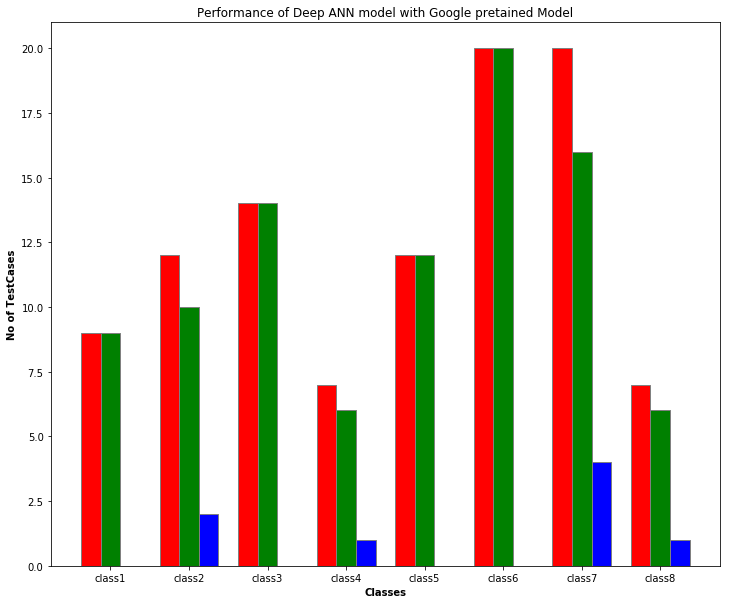

In [179]:
import matplotlib.pyplot as plt 
   
# set width of bar 
barWidth = 0.25
fig = plt.subplots(figsize =(12, 10)) 
   
# set height of bar 
correct = [9, 10, 14, 6,12,20,16,6] 
wrong = [0,2,0,1,0,0,4,1] 
total = [9,12,14,7,12,20,20,7]
   
# Set position of bar on X axis 
br1 = np.arange(8) 
br2 = [x + barWidth for x in br1] 
br3 = [x + barWidth for x in br2] 
   
# Make the plot 
plt.title('Performance of Deep ANN model with Google pretained Model') 
plt.bar(br1, total, color ='r', width = barWidth, edgecolor ='grey', label ='Total') 
plt.bar(br2, correct, color ='g', width = barWidth, edgecolor ='grey', label ='Correctly predicted') 
plt.bar(br3, wrong, color ='b', width = barWidth,  edgecolor ='grey', label ='wrongly predicted') 

   
# Adding Xticks  
plt.xlabel('Classes', fontweight ='bold') 
plt.ylabel('No of TestCases', fontweight ='bold') 
plt.xticks([r + barWidth for r in range(len(IT))], 
           ['class1', 'class2', 'class3', 'class4', 'class5', 'class6','class7','class8']) 
   
plt.show()